In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
from tqdm import tqdm
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
### model path
MODEL_PATH = 'models/'

### hyperparameters
BATCH_SIZE = 128
IMAGE_SIZE = 394
LEARNING_RATE = 0.001

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

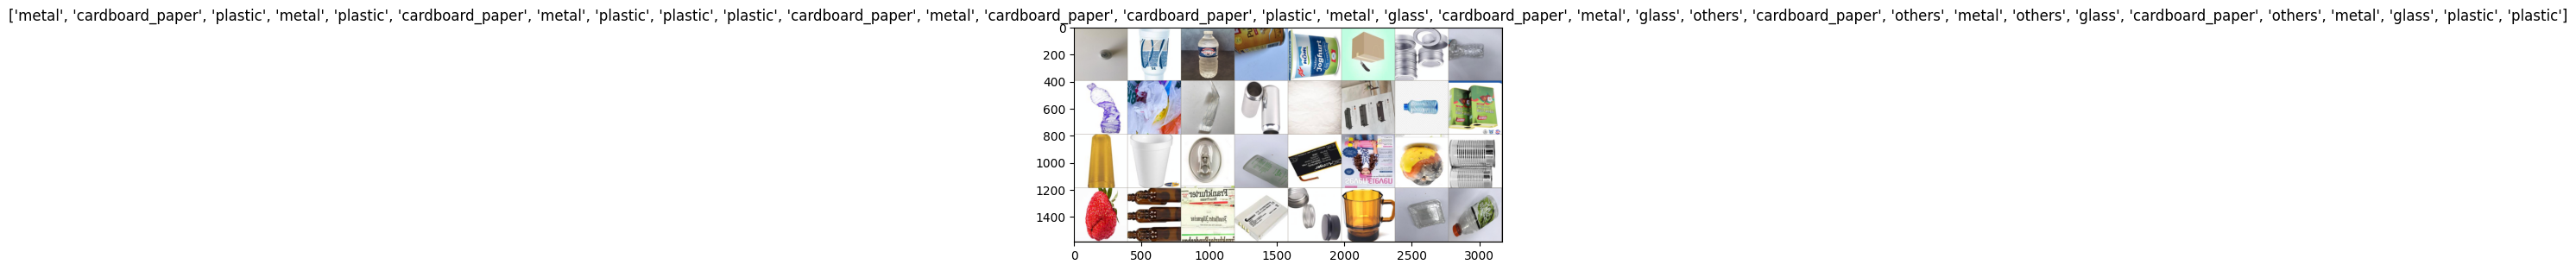

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
# TODO: save 5 ckpts
# def save_k_checkpoints

def train_model(model, criterion, optimizer, scheduler, model_path, num_epochs=25):
    os.makedirs(model_path, exist_ok=True)
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                if scheduler:
                    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                ckpt_path = os.path.join(model_path, f"ckpt_{epoch}_{epoch_acc:.4f}.pth")
                torch.save(model.state_dict(), ckpt_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_conv = torchvision.models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# freeze all layers
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, len(class_names))
)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.parameters(), lr=LEARNING_RATE)

exp_lr_scheduler = None


In [8]:
EXPERIMENT_NAME = 'init'
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                         model_path=os.path.join(MODEL_PATH, EXPERIMENT_NAME), num_epochs=25)

Epoch 0/24
----------


100%|██████████| 348/348 [01:13<00:00,  4.74it/s]


train Loss: 0.6611 Acc: 0.7672


100%|██████████| 44/44 [00:09<00:00,  4.51it/s]


val Loss: 0.3925 Acc: 0.8728
Training complete in 1m 23s
Best val Acc: 0.872753
Epoch 1/24
----------


100%|██████████| 348/348 [01:11<00:00,  4.89it/s]


train Loss: 0.4851 Acc: 0.8278


100%|██████████| 44/44 [00:08<00:00,  5.42it/s]


val Loss: 0.3469 Acc: 0.8893
Training complete in 2m 43s
Best val Acc: 0.889288
Epoch 2/24
----------


100%|██████████| 348/348 [01:11<00:00,  4.90it/s]


train Loss: 0.4248 Acc: 0.8508


100%|██████████| 44/44 [00:08<00:00,  5.36it/s]


val Loss: 0.3046 Acc: 0.8994
Training complete in 4m 2s
Best val Acc: 0.899353
Epoch 3/24
----------


100%|██████████| 348/348 [01:11<00:00,  4.89it/s]


train Loss: 0.4003 Acc: 0.8559


100%|██████████| 44/44 [00:08<00:00,  5.40it/s]


val Loss: 0.2776 Acc: 0.9080
Training complete in 5m 21s
Best val Acc: 0.907980
Epoch 4/24
----------


100%|██████████| 348/348 [00:54<00:00,  6.44it/s]


train Loss: 0.3820 Acc: 0.8640


100%|██████████| 44/44 [00:05<00:00,  7.43it/s]


val Loss: 0.2611 Acc: 0.9137
Training complete in 6m 21s
Best val Acc: 0.913731
Epoch 5/24
----------


100%|██████████| 348/348 [00:48<00:00,  7.20it/s]


train Loss: 0.3569 Acc: 0.8724


100%|██████████| 44/44 [00:08<00:00,  5.34it/s]


val Loss: 0.2384 Acc: 0.9152
Training complete in 7m 18s
Best val Acc: 0.915169
Epoch 6/24
----------


100%|██████████| 348/348 [01:11<00:00,  4.83it/s]


train Loss: 0.3394 Acc: 0.8809


100%|██████████| 44/44 [00:08<00:00,  5.32it/s]


val Loss: 0.2339 Acc: 0.9295
Training complete in 8m 38s
Best val Acc: 0.929547
Epoch 7/24
----------


100%|██████████| 348/348 [01:12<00:00,  4.83it/s]


train Loss: 0.3206 Acc: 0.8869


100%|██████████| 44/44 [00:08<00:00,  5.32it/s]


val Loss: 0.2277 Acc: 0.9202
Training complete in 9m 59s
Best val Acc: 0.929547
Epoch 8/24
----------


100%|██████████| 348/348 [01:11<00:00,  4.84it/s]


train Loss: 0.3160 Acc: 0.8913


100%|██████████| 44/44 [00:08<00:00,  5.36it/s]


val Loss: 0.2130 Acc: 0.9267
Training complete in 11m 19s
Best val Acc: 0.929547
Epoch 9/24
----------


100%|██████████| 348/348 [01:11<00:00,  4.88it/s]


train Loss: 0.2895 Acc: 0.8983


100%|██████████| 44/44 [00:08<00:00,  5.40it/s]


val Loss: 0.2001 Acc: 0.9303
Training complete in 12m 39s
Best val Acc: 0.930266
Epoch 10/24
----------


100%|██████████| 348/348 [01:11<00:00,  4.87it/s]


train Loss: 0.2805 Acc: 0.9025


100%|██████████| 44/44 [00:08<00:00,  5.40it/s]


val Loss: 0.1921 Acc: 0.9331
Training complete in 13m 58s
Best val Acc: 0.933142
Epoch 11/24
----------


  5%|▌         | 18/348 [00:04<01:18,  4.20it/s]


KeyboardInterrupt: 